# Drilling Activity Prediction: Data Modeling - SARIMA

- Import dataset and resample to monthly data
- Use oil dataset to predict oil rig count:
    - Find what hyperparameters to be used in the model (p,d,q)
    - Train/test split
    - Create ARIMA model and fit with data
    - Generate Forecast and compare against Test set
    - Evaluation Measures
    - Refit the model with 100% of data and make REAL Forecasting    
    
    
 - Create ARIMA model with Gas dataframe to predict Gas Rig Count

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load specific forecasting tools
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse, mse, meanabs
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfoil = pd.read_csv('dfoil.csv',index_col=0,parse_dates=True)
dfoil = dfoil.resample('M').mean()
dfoil.index.freq = 'M'


dfgas = pd.read_csv('dfgas.csv',index_col=0,parse_dates=True)
dfgas = dfgas.resample('M').mean()
dfgas.index.freq = 'M'

Before we can apply an ARIMA forecasting model, we need to review the components of one.<br>
ARIMA, or Autoregressive Independent Moving Average is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period.
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


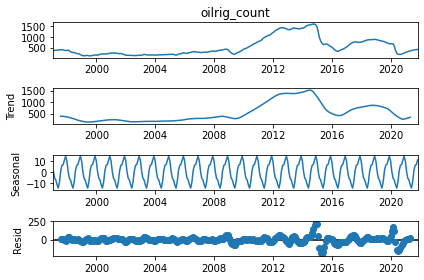

In [3]:
oil_result = seasonal_decompose(dfoil['oilrig_count'], model='additive')  # model='add' also works
oil_result.plot();

In [4]:
nobs = 12

In [5]:
stepwise_fit = auto_arima(dfoil['oilrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=nobs,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2965.143, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2964.110, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2595.587, Time=0.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2962.119, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2595.900, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=2596.893, Time=0.47 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=2597.400, Time=0.37 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2595.435, Time=0.17 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=2597.316, Time=0.51 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=2599.051, Time=0.67 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2963.810, Time=0.11 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2496.812, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2498.442, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -1172.476
Date:                Mon, 08 Nov 2021   AIC                           2354.952
Time:                        16:56:48   BIC                           2373.421
Sample:                             0   HQIC                          2362.346
                                - 298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9537      0.038     24.900      0.000       0.879       1.029
ar.L2         -0.3511      0.074     -4.748      0.000      -0.496      -0.206
ar.L3          0.1239      0.060      2.050      0.040       0.005       0.242
ma.L1          0.9349      0.026     36.142      0.000       0.884       0.986
sigma2       154.7357      4.752     32.560      0.000     145.421     164.050
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              5590.79
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               4.45   Skew:                            -3.08
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

It looks like the order (3,1,1) is recommended for oil df.

#### Train/test split

- We will evaluate the model forecasting 12 months ahead (1 year)
- Train test split. Test df will have 12 data points

In [6]:
train = dfoil.iloc[:len(dfoil)-nobs]
test = dfoil.iloc[len(dfoil)-nobs:]

#### Fit SARIMA model

In [7]:
oil_model = SARIMAX(train['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

#### Generate Forecast values and plot results

In [8]:
#12 months forecast
start=len(train)
end=len(train)+len(test)-1
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count SARIMAX(3,1,1) Predictions')

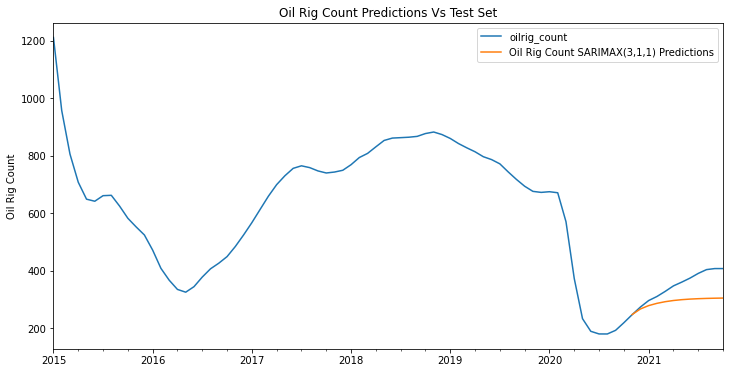

In [9]:
# Plot predictions against known values
title = 'Oil Rig Count Predictions Vs Test Set'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count']['2015':].plot(legend=True,figsize=(12,6),title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Evaluation Metrics

In [10]:
RMSE1 = rmse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MSE1 = mse(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)
MAE1 = meanabs(dfoil['oilrig_count'].loc[test.index.min():],oil_predictions)

print(f"""Oil Rig SARIMA(3,1,1) RMSE: {RMSE1:.3f}
Oil Rig SARIMA(3,1,1) MSE: {MSE1:.3f}
Oil Rig SARIMA(3,1,1) MAE: {MAE1:.3f}\n
Oil Rig Mean Value: {dfoil['oilrig_count'][-nobs:].mean():.3f}
Oil Rig std Value: {dfoil['oilrig_count'][-nobs:].std():.3f}
Oil Rig Percent Change: {RMSE1/dfoil['oilrig_count'][-nobs:].mean()*100:.3f}%""")

Oil Rig SARIMA(3,1,1) RMSE: 66.322
Oil Rig SARIMA(3,1,1) MSE: 4398.668
Oil Rig SARIMA(3,1,1) MAE: 55.252

Oil Rig Mean Value: 345.055
Oil Rig std Value: 54.791
Oil Rig Percent Change: 19.221%


#### Fit Model with 100% of Data and forecast Real Future

In [11]:
oil_model = SARIMAX(dfoil['oilrig_count'],order=(3,1,1))
oil_results = oil_model.fit()

In [12]:
start=len(dfoil)
end=len(dfoil)+nobs
oil_predictions = oil_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Oil Rig Count SARIMAX(3,1,1) Predictions')

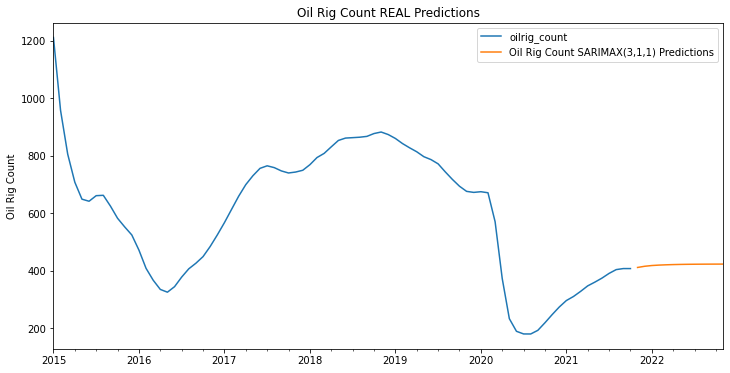

In [13]:
# Plot predictions against known values
title = 'Oil Rig Count REAL Predictions'
ylabel='Oil Rig Count'
xlabel=''

ax = dfoil['oilrig_count']['2015':].plot(legend=True,figsize=(12,6),title=title)
oil_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

#### Create model with Gas Rig Counts

In [14]:
stepwise_fit = auto_arima(dfgas['gasrig_count'], start_p=0, start_q=0,
                          max_p=6, max_q=3, m=nobs,
                          seasonal=True,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=2856.211, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2853.367, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2446.106, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2507.177, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2851.947, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=2445.238, Time=0.03 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=2446.116, Time=0.16 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=2388.371, Time=0.07 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2389.692, Time=0.23 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=2389.608, Time=0.22 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=2391.395, Time=0.43 sec
 ARIMA(3,1,0)(0,0,0)[12] intercept   : AIC=2380.127, Time=0.10 sec
 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2381.190, Time=0.25 sec
 ARIMA(3,1,0)(0,0,1)[12]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  298
Model:               SARIMAX(4, 1, 1)   Log Likelihood               -1136.886
Date:                Mon, 08 Nov 2021   AIC                           2285.772
Time:                        16:57:09   BIC                           2307.935
Sample:                             0   HQIC                          2294.645
                                - 298                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7714      0.049     15.674      0.000       0.675       0.868
ar.L2         -0.0973      0.080     -1.217      0.223      -0.254       0.059
ar.L3          0.2718      0.084      3.222      0.001       0.106       0.437
ar.L4         -0.2546      0.064     -3.964      0.000      -0.380      -0.129
ma.L1          0.8439      0.036     23.591      0.000       0.774       0.914
sigma2       122.1736      7.113     17.175      0.000     108.231     136.116
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                89.01
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.16   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
train = dfgas.iloc[:len(dfgas)-nobs]
test = dfgas.iloc[len(dfgas)-nobs:]
gas_model = SARIMAX(train['gasrig_count'],order=(4,1,1))
gas_results = gas_model.fit()

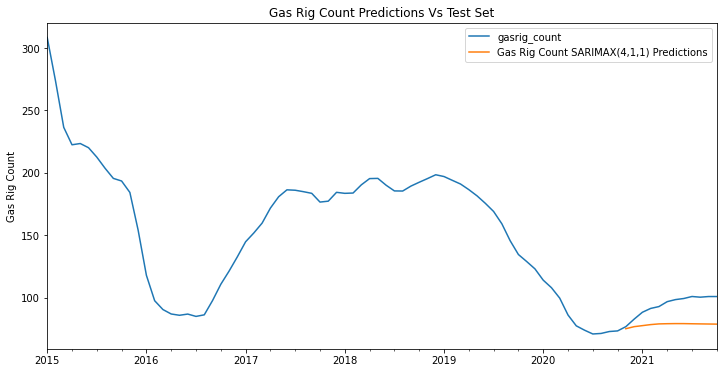

In [16]:
start=len(train)
end=len(train)+len(test)-1
gas_predictions = gas_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Gas Rig Count SARIMAX(4,1,1) Predictions')
# Plot predictions against known values
title = 'Gas Rig Count Predictions Vs Test Set'
ylabel='Gas Rig Count'
xlabel=''

ax = dfgas['gasrig_count']['2015':].plot(legend=True,figsize=(12,6),title=title)
gas_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [17]:
RMSE2 = rmse(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)
MSE2 = mse(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)
MAE2 = meanabs(dfgas['gasrig_count'].loc[test.index.min():],gas_predictions)

print(f"""Gas Rig SARIMA(4,1,1) RMSE: {RMSE2:.3f}
Gas Rig SARIMA(4,1,1) MSE: {MSE2:.3f}
Gas Rig SARIMA(4,1,1) MAE: {MAE2:.3f}\n
Gas Rig Mean Value: {dfgas['gasrig_count'][-nobs:].mean():.3f}
Gas Rig std Value: {dfgas['gasrig_count'][-nobs:].std():.3f}
Gas Rig Percent Change: {RMSE2/dfgas['gasrig_count'][-nobs:].mean()*100:.3f}%""")

Gas Rig SARIMA(4,1,1) RMSE: 17.085
Gas Rig SARIMA(4,1,1) MSE: 291.883
Gas Rig SARIMA(4,1,1) MAE: 15.785

Gas Rig Mean Value: 94.254
Gas Rig std Value: 7.984
Gas Rig Percent Change: 18.126%


#### Gas Rig Count REAL PREDICTIONS with 100% data

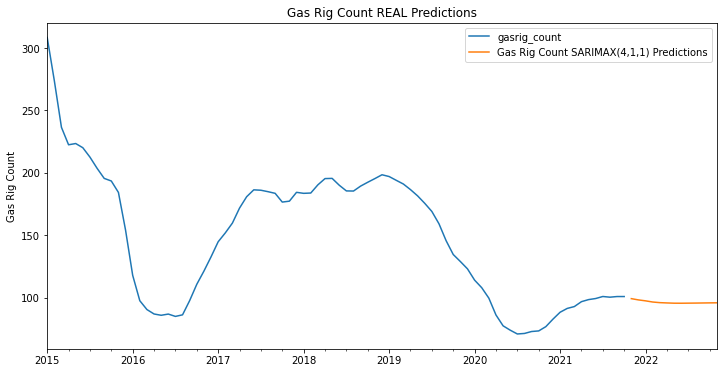

In [18]:
gas_model = SARIMAX(dfgas['gasrig_count'],order=(4,1,1),m=nobs)
gas_results = gas_model.fit()
start=len(dfgas)
end=len(dfgas)+nobs
gas_predictions = gas_results.predict(start=start, end=end, dynamic=False, typ='levels').rename('Gas Rig Count SARIMAX(4,1,1) Predictions')
# Plot predictions against known values
title = 'Gas Rig Count REAL Predictions'
ylabel='Gas Rig Count'
xlabel=''

ax = dfgas['gasrig_count']['2015':].plot(legend=True,figsize=(12,6),title=title)
gas_predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);